# UNUSED CODE

##

## API full set of data with:
- MATCH: Tournament, Date, League, GameLength, Team1, Team2, T1 Score, T2 Score
- PLAYERS

In [2]:
#https://lol.fandom.com/wiki/Help:Leaguepedia_API
""" 
    This is the website I used to figure out how to query API from Leaguepedia (storing all match statistics)
"""
import mwclient

#This is the LeaguePedia website that stores all match and team statistics
site = mwclient.Site('lol.fandom.com', path='/')


"""
    I searched for a quicker way to iterate for loops because it took too long to run
"""
#https://github.com/tqdm/tqdm 
from tqdm.notebook import tqdm

#pre-set the leagues I want to look at - all those that will qualify to worlds
leagues=['GPL','IWCQ','WCS','LCS','LEC','LCK','LPL','CBLOL','LCL','LJL','LLA','OPL','PCS','VCS','TCL','LMS','LST','NA LCS','EU LCS','LLN','CLS']

#create an empty list to store my dataset
results = []

#for loop to create my data base of match stats
for league in tqdm(leagues):
    off=0
    
    #while loop to retrive data thruogh API
    while True:
        #API query
        response = site.api('cargoquery',
                            offset=str(off),
                            
                            limit="500",
                            
                            #retrive tables
                            tables = "ScoreboardGames=SG, ScoreboardPlayers=SP,Tournaments=T, Leagues=L",
                            
                            #retrive fields as columns
                            fields="T.Name=Tournament,\
                                    L.League_Short=League,\
                                    SP.Link,\
                                    SG.DateTime_UTC, SG.Gamelength, SG.Team1, SG.Team2, SG.Team1Score, SG.Team2Score", 
                            
                            #set condition (only include specified leagues)
                            where = 'L.League_Short = "'+league+'"',
                            
                            #similar to vlookup in the web pages
                            join_on = "SG.OverviewPage=T.OverviewPage, T.League = L.League, SP.MatchId=SG.MatchId")
        
        #add to database
        results += response["cargoquery"] 
        
        #speed
        off=off+500
        if(len(response["cargoquery"])<500): break
        

  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt



## Import df_Scoreboard

In [ ]:
import pandas as pd
df_Scoreboard = pd.DataFrame([ a['title'] for a in results ])
df_Scoreboard = df_Scoreboard.drop("DateTime UTC__precision", axis=1)
df_Scoreboard.sort_values("DateTime UTC")
df_Scoreboard.head()
#df_Scoreboard.to_csv("Scoreboard.csv")

## API LCK set of data with PLAYERS team, ID, age, nationality, birthday

In [ ]:
#https://lol.fandom.com/wiki/Help:Leaguepedia_API
""" 
    This is the website I used to figure out how to query API from Leaguepedia (storing all match statistics)
"""
import mwclient

#This is the LeaguePedia website that stores all match and team statistics
site = mwclient.Site('lol.fandom.com', path='/')


"""
    I searched for a quicker way to iterate for loops because it took too long to run
"""
#https://github.com/tqdm/tqdm 
from tqdm.notebook import tqdm

#pre-set the leagues I want to look at - all those that will qualify to worlds
#leagues=['LCS','LEC','LCK','LPL','CBLOL','LJL','LLA','PCS','VCS']
leagues=['LCK']

#create an empty list to store my dataset
results = []

#for loop to create my data base of match stats
for league in tqdm(leagues):
    off=0
    
    #while loop to retrive data thruogh API
    while True:
        #API query
        response = site.api('cargoquery',
                            offset=str(off),
                            
                            limit="max",
                            
                            #retrive tables
                            tables = "Teams=T, Players=P",
                            
                            #retrive fields as columns
                            fields="P.Team=Team, P.ID=ID, P.Nationality, P.Country,P.Birthdate,\
                                    T.Region=Region, T.Short", 
                            
                            #set condition 
                            #where = 'T.Name = P.Team',
                            
                            #similar to vlookup in the web pages
                            join_on = "T.Name = P.Team")
        
        #add to database
        results += response["cargoquery"] 
        
        #speed
        off=off+500
        if(len(response["cargoquery"])<500): break

        
        
import pandas as pd
df_Players = pd.DataFrame([ a['title'] for a in results ])

#drop birthdate precision
df_Players = df_Players.drop("Birthdate__precision", axis=1)

df_Players.head()
#df_Players.to_csv("Players.csv")

In [ ]:
df_stats = df_Scoreboard.merge(df_Players, left_on = 'Team1', right_on = 'Team', how = 'left')
df_stats.head()
df_stats.to_csv("Merged.csv")

In [ ]:
#####################################################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################
#####################################################################################################################################################

# 

# USED CODE

## 

# API full set of Scoreboard data with: 
- MATCH: Tournament, Date, League, GameLength, Team1, Team2, T1 Score, T2 Score

In [169]:
import mwclient
site = mwclient.Site('lol.fandom.com', path='/')

from tqdm.notebook import tqdm

leagues=['GPL','IWCQ','WCS','LCS','LEC','LCK','LPL','CBLOL','LCL','LJL','LLA','OPL','PCS','VCS','TCL','LMS','LST','NA LCS','EU LCS','LLN','CLS']

results = []

for league in tqdm(leagues):
    off=0
    
    while True:
    
        response = site.api('cargoquery',
                            offset=str(off),
                            
                            limit="max",
                            
                            tables = "ScoreboardGames=SG,Tournaments=T, Leagues=L",
                            
                            fields="T.Name=Tournament,\
                                    L.League_Short=League,\
                                    SG.DateTime_UTC=Date, SG.Gamelength, SG.Team1, SG.Team2, SG.Team1Score, SG.Team2Score,SG.WinTeam", 
                            
                            where = 'L.League_Short = "'+league+'"',
                            
                            join_on = "SG.OverviewPage=T.OverviewPage, T.League = L.League")
    
        results += response["cargoquery"] 
        
        off=off+500
        if(len(response["cargoquery"])<500): break

  0%|          | 0/21 [00:00<?, ?it/s]

## Convert to Panda DataFrame and Clean Data

In [170]:
#import pandas package
import pandas as pd

#convert to dataframe from dictionary
df_Scoreboard = pd.DataFrame([ a['title'] for a in results ])

#drop unused column
df_Scoreboard = df_Scoreboard.drop("Date__precision", axis=1)

#sort by date
df_Scoreboard.sort_values(by = "Date",inplace=True)

#split date and time
df_Scoreboard["Date"] = pd.to_datetime(df_Scoreboard["Date"])
df_Scoreboard["Year"]= df_Scoreboard["Date"].dt.year

#convert Team 1 & 2 score as integers
df_Scoreboard = df_Scoreboard.astype({'Team1Score':'int','Team2Score':'int'})

#no index
df_Scoreboard = df_Scoreboard.reset_index(drop=True)

#preview first few rows
df_Scoreboard.head()

#save as csv
df_Scoreboard.to_csv("Scoreboard.csv", index=False)

## Shortcut - Import df_Scoreboard

In [195]:
import pandas as pd
df_Scoreboard = pd.read_csv("Scoreboard.csv")
df_Scoreboard.head()

,Tournament,League,Date,Gamelength,Team1,Team2,Team1Score,Team2Score,WinTeam,Year,Region_T1,Team_T1,Region_code_T1,Region_T2,Team_T2,Region_code_T2,Region_Win,Team_Win,Region_code_Win,Blue/Red
0,Worlds Season 1,WCS,18/06/2011 08:30,45:09:00,against All authority,Epik Gamer,0,1,Epik Gamer,2011,Europe,aAa,EMEA,North America,EPIK,NaN,North America,EPIK,NaN,Red
1,Worlds Season 1,WCS,18/06/2011 09:45,29:38:00,Fnatic,Team Pacific,1,0,Fnatic,2011,EMEA,FNC,EMEA,SEA,PCFC,PCS,EMEA,FNC,EMEA,Blue
2,Worlds Season 1,WCS,18/06/2011 11:00,41:18:00,against All authority,Fnatic,1,0,against All authority,2011,Europe,aAa,EMEA,EMEA,FNC,EMEA,Europe,aAa,EMEA,Blue
3,Worlds Season 1,WCS,18/06/2011 11:00,28:55:00,Epik Gamer,Team Pacific,1,0,Epik Gamer,2011,North America,EPIK,NaN,SEA,PCFC,PCS,North America,EPIK,NaN,Blue
4,Worlds Season 1,WCS,18/06/2011 12:15,24:13:00,against All authority,Team Pacific,1,0,against All authority,2011,Europe,aAa,EMEA,SEA,PCFC,PCS,Europe,aAa,EMEA,Blue


# 

# Get All Teams Region data
## API full set of data with: (much faster)
- TEAM: Name, Region, Abbreviation 

In [177]:
import mwclient
site = mwclient.Site('lol.fandom.com', path='/')

from tqdm.notebook import tqdm

leagues=['GPL','IWCQ','WCS','LCS','LEC','LCK','LPL','CBLOL','LCL','LJL','LLA','OPL','PCS','VCS','TCL','LMS','LST','NA LCS','EU LCS','LLN','CLS']

results = []

for league in tqdm(leagues):
    off=0
    
    while True:

        response = site.api("cargoquery",
                            offset=str(off),
                            
                            limit="max",
                            
                            tables = "Teams=T",
                            
                            fields="T.Name=Team, T.Region=Region, T.Short=Team_abbr")
                            
        results += response["cargoquery"] 
        
        off=off+500
        if(len(response["cargoquery"])<500): break

  0%|          | 0/21 [00:00<?, ?it/s]

## Convert to Panda DataFrame and Clean Data

In [178]:
import pandas as pd
df_TeamRegion = pd.DataFrame([ a['title'] for a in results ])

#clean data - remove NaN's and duplicates
df_TeamRegion = df_TeamRegion.dropna()
df_TeamRegion = df_TeamRegion.drop_duplicates(subset="Team")

#no index
df_TeamRegion = df_TeamRegion.reset_index(drop=True)

#preview first few rows
df_TeamRegion.head()

#save as csv
df_TeamRegion.to_csv("TeamRegion.csv", index=False)

## Shortcut - Import df_TeamRegion

In [157]:
import pandas as pd
df_TeamRegion = pd.read_csv("TeamRegion.csv")
df_TeamRegion.head()

,Team,Region,Team_abbr
2866,Rainbow7,Latin America,R7
2867,Rogue (European Team),Europe,RGE
2868,PEACE (Oceanic Team),PCS,PCE
2869,Evil Geniuses.NA,North America,EG
2870,Istanbul Wildcats,EMEA,IW


## Add DAMWON Gaming and DWG KIA to df_Team_Region
 - Wolrds Winners 2020 and 2021

In [186]:
#DAMWON Gaming and DWG KIA both renamed - They are the same team...
#create new rows for DAMWON Gaming and DWG KIA
df_TeamRegion2 = {"Team":"DAMWON Gaming",
                  "Region":"Korea",
                  "Team_abbr":"DK"}

df_TeamRegion3 = {"Team":"DWG KIA",
                  "Region":"Korea",
                  "Team_abbr":"DK"}

#add new rows to df
df_TeamRegion = df_TeamRegion.append(df_TeamRegion2, ignore_index=True)
df_TeamRegion = df_TeamRegion.append(df_TeamRegion3, ignore_index=True)
df_TeamRegion.head()

#re-save as csv
df_TeamRegion.to_csv("TeamRegion.csv", index=False)

C:\Users\vivia\AppData\Local\Temp\ipykernel_7068\1473232610.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_TeamRegion = df_TeamRegion.append(df_TeamRegion2, ignore_index=True)
C:\Users\vivia\AppData\Local\Temp\ipykernel_7068\1473232610.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_TeamRegion = df_TeamRegion.append(df_TeamRegion3, ignore_index=True)


In [187]:
#create a dictionary to match teams to regions
#some of them have merged and changed so they should be analyzed together
dict_regions_code = {
    'Africa':'EMEA',
    'Brazil':'BR',
    'China':'CN',
    'CIS':'INT',
    'EMEA':'EMEA',
    'Europe':'EMEA',
    'International':'INT',
    'Japan':'JP',
    'Korea':'KR',
    'LAN':'INT',
    'LAS':'INT',
    'Latin America':'LAT',
    'LMS':'INT',
    'MENA':'INT',
    'North America':'NA',
    'Oceania':'PCS',
    'PCS':'PCS',
    'SEA':'PCS',
    'Turkey':'EMEA',
    'Vietnam':'VN'
}

#define function to get region code from dictionary
def get_region_code(region):
    return dict_regions_code[region]

## Matching old to new team names 
- only the ones that cannot be found in df above
- some old team names may still not be matched to new ones unfortunately

In [188]:
#import manually stored file for matching old to new team names
df_OldtoNewTeams = pd.read_csv("OldtoNewTeams.csv")

#concatenate the two dataframes to add the new list of teams
df_TeamRegion = pd.concat([df_TeamRegion,df_OldtoNewTeams])
df_TeamRegion.to_csv("TeamRegion.csv",index=False)

## Merge team region with region codes

In [192]:
import pandas as pd
#import manually saved csv with Region and code - not accessible on Leaguepedia
df_Region_code = pd.read_csv("Region_Code.csv",na_filter = False) #interprets NA as string instead of NaN value

#merge with region_code
df_TeamRegion_code = df_TeamRegion.merge(df_Region_code, on = 'Region', how = 'left')
df_TeamRegion_code.drop(columns=["Region"], inplace = True)
df_TeamRegion_code.head()

#save as csv
df_TeamRegion_code.to_csv("TeamRegion.csv",index=False)

## Merge tables to get:
- Team1, Team2, WinTeam Regions
- blue/red side

In [32]:
# Add Region and Region Code to Scoreboard

In [206]:
#first merge for Team 1
df_team1 = df_Scoreboard.merge(df_TeamRegion_code, left_on = 'Team1', right_on = 'Team', how = 'left')
df_team1.head()

#then merge for Team 2
df_team1and2 = df_team1.merge(df_TeamRegion_code, left_on = 'Team2', right_on = 'Team', how = 'left')

#then merge for WinTeam
df_team1and2_andwinner = df_team1and2.merge(df_TeamRegion_code, left_on = 'WinTeam', right_on = 'Team', how = 'left')

#clean dataframe
df_team1and2_andwinner.drop(columns=["Team_x","Team_y","Team"], inplace = True)
df_team1and2_andwinner.rename(columns={'Region_x':'Region_T1','Team_abbr_x':'Team_T1','Region_code_x':'Region_code_T1','Region_y':'Region_T2','Team_abbr_y':'Team_T2','Region_code_y':'Region_code_T2','Region':'Region_Win','Team_abbr':'Team_Win','Region_code':'Region_code_Win'},inplace=True)

df_team1and2_andwinner.head()

,Tournament,League,Date,Gamelength,Team1,Team2,Team1Score,Team2Score,WinTeam,Year,...,Region_Win,Team_Win,Region_code_Win,Blue/Red,Team_T1,Region_code_T1,Team_T2,Region_code_T2,Team_Win,Region_code_Win
0,Worlds Season 1,WCS,18/06/2011 08:30,45:09:00,against All authority,Epik Gamer,0,1,Epik Gamer,2011,...,North America,EPIK,NaN,Red,aAa,EMEA,EPIK,NaN,EPIK,NaN
1,Worlds Season 1,WCS,18/06/2011 09:45,29:38:00,Fnatic,Team Pacific,1,0,Fnatic,2011,...,EMEA,FNC,EMEA,Blue,FNC,EMEA,PCFC,PCS,FNC,EMEA
2,Worlds Season 1,WCS,18/06/2011 11:00,41:18:00,against All authority,Fnatic,1,0,against All authority,2011,...,Europe,aAa,EMEA,Blue,aAa,EMEA,FNC,EMEA,aAa,EMEA
3,Worlds Season 1,WCS,18/06/2011 11:00,28:55:00,Epik Gamer,Team Pacific,1,0,Epik Gamer,2011,...,North America,EPIK,NaN,Blue,EPIK,NaN,PCFC,PCS,EPIK,NaN
4,Worlds Season 1,WCS,18/06/2011 12:15,24:13:00,against All authority,Team Pacific,1,0,against All authority,2011,...,Europe,aAa,EMEA,Blue,aAa,EMEA,PCFC,PCS,aAa,EMEA


In [197]:
#import manually saved csv with Region and code - not accessible on Leaguepedia
df_Region_code = pd.read_csv("Region_Code.csv",na_filter = False) #interprets NA as string instead of NaN value

#first merge team1
df_team1_code = df_team1and2_andwinner.merge(df_Region_code, left_on = 'Region_T1', right_on = 'Region', how = 'left')
df_team1_code.drop(columns="Region",inplace=True)

#then merge team2
df_team1and2_code = df_team1_code.merge(df_Region_code, left_on = 'Region_T2', right_on = 'Region', how = 'left')
df_team1and2_code.drop(columns="Region",inplace=True)

#then merge WinTeam
df_team1and2_andwinner_code = df_team1and2_code.merge(df_Region_code, left_on = 'Region_Win', right_on = 'Region', how = 'left')
df_team1and2_andwinner_code.drop(columns="Region",inplace=True)

#clean dataframe
df_team1and2_andwinner_code.rename(columns={"Region_code_x":"Region_code_T1","Region_code_y":"Region_code_T2","Region_code":"Region_code_Win"},inplace=True)

df_team1and2_andwinner_code.head()

,Tournament,League,Date,Gamelength,Team1,Team2,Team1Score,Team2Score,WinTeam,Year,...,Blue/Red,Team_T1,Region_code_T1,Team_T2,Region_code_T2,Team_Win,Region_code_Win,Region_code_T1,Region_code_T2,Region_code_Win
0,Worlds Season 1,WCS,18/06/2011 08:30,45:09:00,against All authority,Epik Gamer,0,1,Epik Gamer,2011,...,Red,aAa,EMEA,EPIK,NA,EPIK,NA,EMEA,NA,NA
1,Worlds Season 1,WCS,18/06/2011 09:45,29:38:00,Fnatic,Team Pacific,1,0,Fnatic,2011,...,Blue,FNC,EMEA,PCFC,PCS,FNC,EMEA,EMEA,PCS,EMEA
2,Worlds Season 1,WCS,18/06/2011 11:00,41:18:00,against All authority,Fnatic,1,0,against All authority,2011,...,Blue,aAa,EMEA,FNC,EMEA,aAa,EMEA,EMEA,EMEA,EMEA
3,Worlds Season 1,WCS,18/06/2011 11:00,28:55:00,Epik Gamer,Team Pacific,1,0,Epik Gamer,2011,...,Blue,EPIK,NA,PCFC,PCS,EPIK,NA,NA,PCS,NA
4,Worlds Season 1,WCS,18/06/2011 12:15,24:13:00,against All authority,Team Pacific,1,0,against All authority,2011,...,Blue,aAa,EMEA,PCFC,PCS,aAa,EMEA,EMEA,PCS,EMEA


In [57]:
# Add Blue/Red Side to Scoreboard

In [174]:
#get if blue side or red side is winner
for lab, row in df_team1and2_andwinner_code.iterrows():
    if row["Team1"] == row["WinTeam"]:
        df_team1and2_andwinner_code.loc[lab,"Blue/Red"] = "Blue"
    else:
        df_team1and2_andwinner_code.loc[lab,"Blue/Red"] = "Red"
    
df_team1and2_andwinner_code.head()

#save to Scoreboard.csv and df_Scoreboard
df_team1and2_andwinner_code.to_csv("Scoreboard.csv", index=False)
df_Scoreboard = pd.read_csv("Scoreboard.csv")
df_Scoreboard[["Region_code_T1", "Region_code_T2","Region_code_Win"]] = df_Scoreboard[["Region_code_T1", "Region_code_T2","Region_code_Win"]].fillna("NA")
df_Scoreboard.to_csv("Scoreboard.csv", index=False)

#table form - get blue/red count
df_Scoreboard.groupby(["Blue/Red"])["Blue/Red"].count()

Blue/Red
Blue    17310
Red     14818
Name: Blue/Red, dtype: int64

In [210]:
#replace SKT to T1
df_Scoreboard = df_Scoreboard.replace(to_replace = "SKT", value = "T1")
df_Scoreboard.to_csv("Scoreboard.csv", index=False)

#

# Worlds Winners 2011 - 2022

## Get Worlds Tournament only - original dataset contains regional finals

In [211]:
#I want to get the winners of all the Worlds Championships only
#I can't filter from 'WCS' league because it randomly includes regional finals
#But the tournaments that begin with "Worlds" can be identified
df_Scoreboard_Worlds = df_Scoreboard[df_Scoreboard["Tournament"].str.startswith("Worlds")]
df_Scoreboard_Worlds = df_Scoreboard_Worlds.reset_index(drop=True)
df_Scoreboard_Worlds = df_Scoreboard_Worlds.drop_duplicates(keep="first")
df_Scoreboard_Worlds.head
df_Scoreboard_Worlds.to_csv("Scoreboard_Worlds.csv", index=False)

## Graph - Top 10 Team Winners in ALL matches of Worlds

<AxesSubplot: title={'center': 'Top 10 Teams'}, xlabel='Teams', ylabel='Matches won'>

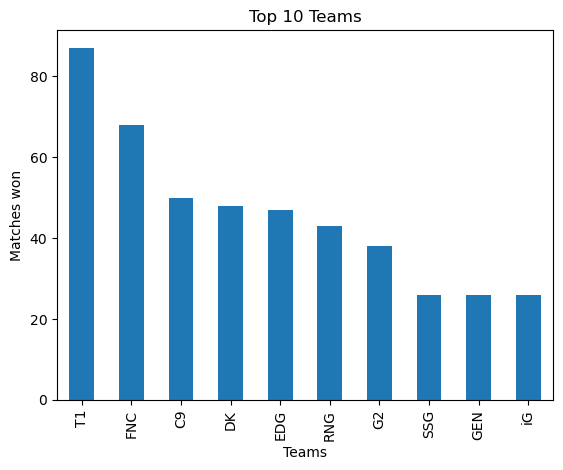

In [212]:
#who won the most matches in Worlds Championship
import seaborn as sns

top_10_teams = (df_Scoreboard_Worlds['Team_Win'].value_counts()).iloc[:10]

#create bar chart of top 10 teams
top_10_teams.plot(kind='bar',title='Top 10 Teams', xlabel = "Teams", ylabel = "Matches won")

## Graph - Top 10 Region Winners in ALL matches of Worlds

<AxesSubplot: title={'center': 'Top 10 Regions'}, xlabel='Regions', ylabel='Matches won'>

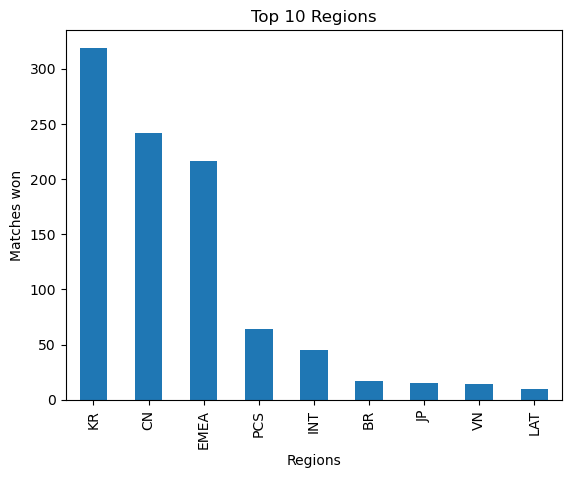

In [213]:
#who won the most matches in Worlds Championship
import seaborn as sns

top_10_regions = (df_Scoreboard_Worlds['Region_code_Win'].value_counts()).iloc[:10]

#create bar chart of top 10 teams
top_10_regions.plot(kind='bar',title='Top 10 Regions', xlabel = "Regions", ylabel = "Matches won")

## Get list of all World Winners - filter who won most matches in Finals

In [214]:
#create function to get winner of each season/worlds 
def get_winner(year):
    finals_year = df_Scoreboard_Worlds[df_Scoreboard_Worlds["Year"]==year]
    winner = finals_year["WinTeam"].value_counts( ).idxmax()
    return winner

#create dictionary for Worlds Winners
years = [i for i in range(2011,2023)]

winners = []
for i in range(2011,2023):
    winners.append(get_winner(i))

dict_worlds_winners = {}
for i in range(len(years)):
    dict_worlds_winners[years[i]] = winners[i]

In [215]:
#create dataframe from dictionary
df_worlds_winners = pd.DataFrame(data = [dict_worlds_winners])
df_worlds_winners = df_worlds_winners.transpose()
df_worlds_winners.reset_index(inplace=True)
df_worlds_winners.columns = ["Year","Winner"]
df_worlds_winners.to_csv("Worlds_Winners.csv",index=False) 

#merge with TeamRegion to get Region_code
df_worlds_winners = df_worlds_winners.merge(df_TeamRegion_code, left_on = "Winner", right_on = "Team", how = "left")
df_worlds_winners = df_worlds_winners.drop(columns="Team")
df_worlds_winners.head()
#df_worlds_winners.to_csv("Worlds_Winners.csv",index=False)

,Year,Winner,Team_abbr,Region_code
0,2011,Fnatic,FNC,EMEA
1,2012,Azubu Frost,AZF,KR
2,2013,SK Telecom T1,T1,KR
3,2014,Samsung White,SSW,KR
4,2015,SK Telecom T1,T1,KR


## Shortcut - Import df_worlds_winners

In [10]:
import pandas as pd
df_worlds_winners = pd.read_csv("Worlds_Winners.csv",index_col=0) 

## Graph - Frequency of Worlds Winner : Teams 

([<matplotlib.axis.YTick at 0x20226c135e0>,
 [Text(0, 0, '0'), Text(0, 1, '1'), Text(0, 2, '2'), Text(0, 3, '3')])

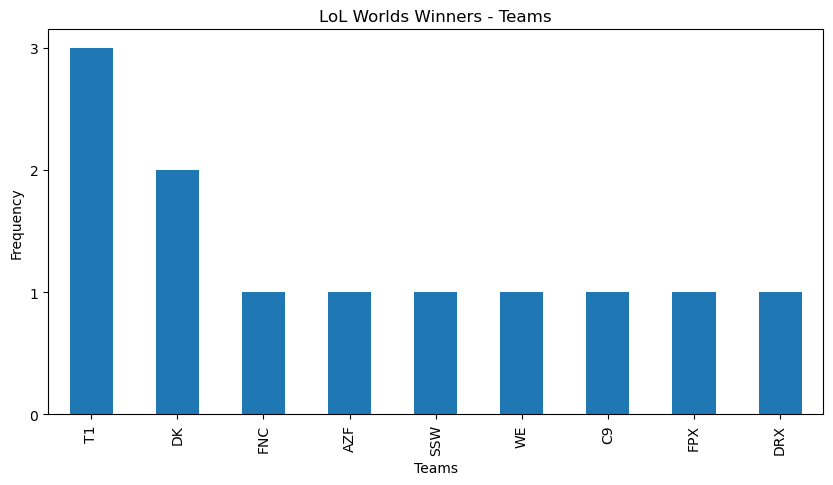

In [216]:
#Plot frequencies of team winners
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax = df_worlds_winners["Team_abbr"].value_counts().plot(kind='bar',
                                    figsize=(10,5),
                                    title="LoL Worlds Winners - Teams")
ax.set_xlabel("Teams")
ax.set_ylabel("Frequency")

import numpy as np
plt.yticks(np.arange(0, 4, 1))

## Graph - Frequency of Worlds Winner : Regions 

([<matplotlib.axis.YTick at 0x2021c685850>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9')])

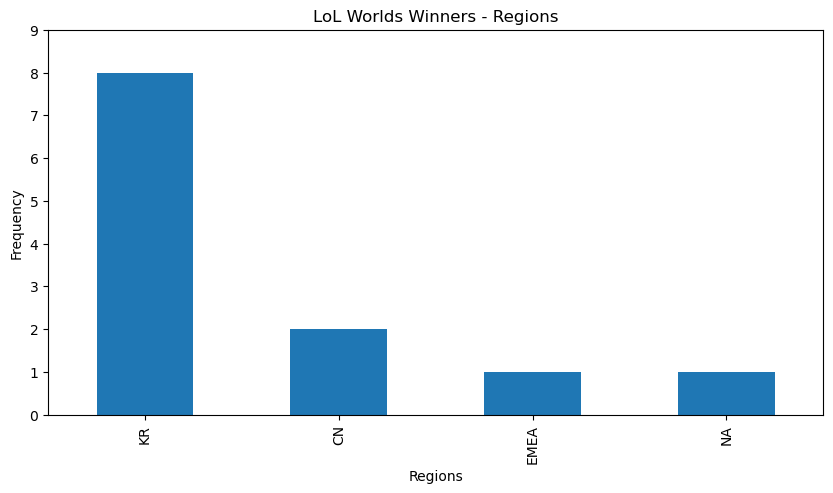

In [61]:
#Plot frequencies of region winners
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax = df_worlds_winners["Region_code"].value_counts().plot(kind='bar',
                                    figsize=(10,5),
                                    title="LoL Worlds Winners - Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Frequency")

import numpy as np
plt.yticks(np.arange(0, 10, 1))

# Get Participation of Regions in Worlds
- to show that Korea participated later but won a lot more matches/worlds finals


## Group by years and find out region participation

In [62]:
#concatenate teams 1 and 2 for full partcipation
data1 = df_Scoreboard_Worlds.groupby(["Year","Region_code_T1"])["Region_code_T1"].count()
data2 = df_Scoreboard_Worlds.groupby(["Year","Region_code_T2"])["Region_code_T2"].count()
data = pd.concat([data1,data2],axis=1)
df_participation = pd.DataFrame(data)
df_participation["Region_T1_T2"]=df_participation["Region_code_T1"] + df_participation["Region_code_T2"] 
df_participation= df_participation.reset_index()
df_participation.rename(columns={df_participation.columns[1]:"Region_Participation",df_participation.columns[4]:"Participation_counts"},inplace=True)
df_participation.head()

#groupby years and regions
participation_data = df_participation.groupby(["Year","Region_Participation"])["Participation_counts"].sum()
participation_data

df_participation_data = pd.DataFrame(participation_data)
df_participation_data

Participation_counts
Year Region_Participation                      
2011 EMEA                                  28.0
     NA                                    22.0
     PCS                                    0.0
2012 CN                                     8.0
     EMEA                                  12.0
...                                         ...
2022 KR                                    72.0
     LAT                                    5.0
     NA                                    28.0
     PCS                                   16.0
     VN                                    15.0

[93 rows x 1 columns]

In [63]:
#compare participation vs wins

#group regions and count wins per region
wins = df_Scoreboard_Worlds.groupby(["Year","Region_code_Win"])["Region_code_Win"].count()

#table for counting wins per region
dfwins = pd.DataFrame(wins)
dfwins.rename(columns={"Region_code_Win":"Win_counts"},inplace=True)
dfwins = dfwins.reset_index()
dfwins.rename(columns={"Region_code_Win":"Region_code"},inplace=True)
dfwins.head()

#table for counting participation per region
dfparticipation = pd.DataFrame(participation_data)
dfparticipation = dfparticipation.reset_index()
dfparticipation.rename(columns={"Region_Participation":"Region_code"},inplace=True)
dfparticipation.head()

#merge tables to compare participation vs win counts
dfcompare_part_wins = dfwins.merge(dfparticipation, on = ["Year","Region_code"], how = "left")
dfcompare_part_wins = dfcompare_part_wins.set_index(["Region_code","Year"])
dfcompare_part_wins.head()

,,Win_counts,Participation_counts
Region_code,Year,,
EMEA,2011,16,28.0
NA,2011,11,22.0
PCS,2011,1,0.0
CN,2012,3,8.0
EMEA,2012,5,12.0


<AxesSubplot: title={'center': 'KR'}, xlabel='Year'>

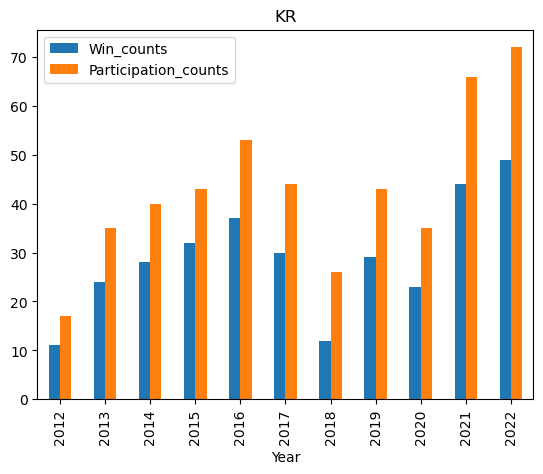

In [86]:
#Graph for participation vs wins
import matplotlib.pyplot as plt

#sample graph for Korea
dfcompare_part_wins_KR = dfcompare_part_wins.loc["KR"]
dfcompare_part_wins_KR.plot(kind="bar", title="KR")

In [67]:
#ratio of participation vs wins
list_regions = list(df_Region_code["Region_code"].unique())
list_regions

#define function for getting wins/participation counts
def get_part_win_ratio(region):
    part_wins_ratio = dfcompare_part_wins.loc[region]["Win_counts"]/dfcompare_part_wins.loc[region]["Participation_counts"]
    return part_wins_ratio.mean()


#make table of region vs ratio
df_ratios = pd.DataFrame()
df_ratios["Regions"]=list_regions
df_ratios["Ratio"] = df_ratios["Regions"].apply(get_part_win_ratio)
    
df_ratios

,Regions,Ratio
0,EMEA,0.465486
1,BR,0.259259
2,CN,0.558659
3,INT,0.343372
4,JP,0.312727
5,KR,0.663383
6,LAT,0.272143
7,NA,0.412855
8,PCS,inf
9,VN,0.292857


In [68]:
#inspect why PCS mean ratio is 'inf'
df_part_wins_ratio_PCS = dfcompare_part_wins.loc["PCS"]["Win_counts"]/dfcompare_part_wins.loc["PCS"]["Participation_counts"]
df_part_wins_ratio_PCS

Year
2011         inf
2012    0.333333
2014    0.428571
2015    0.250000
2016    0.500000
2017    0.315789
2018    0.363636
2019    0.342857
2020    0.400000
2021    0.419355
2022    0.187500
dtype: float64

In [69]:
#remove inf (0/0) from PCS because that's where the inf comes from
import numpy as np
df_part_wins_ratio_PCS.replace([np.inf, -np.inf], np.nan, inplace=True)
df_part_wins_ratio_PCS.dropna(inplace=True)
df_part_wins_ratio_PCS.mean()

#replace PCS mean ratio in table
df_ratios.at[8,"Ratio"] = df_part_wins_ratio_PCS.mean()
df_ratios
#df_ratios.to_csv("Participation_to_Win_Ratio.csv",index=False)

,Regions,Ratio
0,EMEA,0.465486
1,BR,0.259259
2,CN,0.558659
3,INT,0.343372
4,JP,0.312727
5,KR,0.663383
6,LAT,0.272143
7,NA,0.412855
8,PCS,0.354104
9,VN,0.292857


In [ ]:
#can see that KR and CN has participation to win ratio > 50%
#also they have most wins in Worlds
#will also look at EMEA and NA

In [85]:
#dfparticipation_finals_by_region = dfparticipation_finals.reset_index()
#dfparticipation_finals_by_region = dfparticipation_finals_by_region.set_index(["Region_code","Year"])
#dfparticipation_finals_by_region

#dfparticipation_finals = dfparticipation_finals.reset_index()
piv_participation_finals = pd.pivot_table(dfcompare_part_wins, index="Region_code",columns="Year",values="Participation_counts", fill_value=0)
piv_participation_finals

#can see that KR, CN and EMEA has similar number of teams playing in recent 5Y *knockout stage* matches

Year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Region_code,,,,,,,,,,,,
BR,0,0,0,6,6,6,9,5,5,5,9,10
CN,0,8,19,46,21,27,43,47,38,61,51,50
EMEA,28,12,35,24,31,25,52,56,56,53,34,44
INT,0,14,10,6,10,16,17,22,11,14,5,0
JP,0,0,0,0,0,0,0,8,4,5,11,14
KR,0,17,35,40,43,53,44,26,43,35,66,72
LAT,0,0,0,0,0,0,4,12,8,7,0,5
NA,22,8,19,27,19,21,32,34,26,23,31,28
PCS,0,3,0,7,16,6,19,22,35,25,31,16


## Decide to only look at KR, CN, EMEA as a result of analysis:
- Worlds Winners region frequency
- Match winners region frequency
- Entering finals (knockout stage) region frequency

# 

# Get subsets of LCK, LPL, LEC
- top 5 teams to qualify (most match wins)
- calculate elo rating (within regional league)

## Get LCK only - get top 5 teams to qualify to Swiss Round
- and calculate team elo

In [261]:
#get LCK league only
df_Scoreboard_LCK = df_Scoreboard[df_Scoreboard["League"]=="LCK"]
df_Scoreboard_LCK.to_csv("Scoreboard_LCK.csv")

#get top 5 teams winning matches
teams_KR_wins = df_Scoreboard_LCK.groupby(["Team_Win"])["Team_Win"].count()
teams_KR_T1 = df_Scoreboard_LCK.groupby(["Team_T1"])["Team_T1"].count()
teams_KR_T2= df_Scoreboard_LCK.groupby(["Team_T2"])["Team_T2"].count()
teams_KR_part = pd.concat([teams_KR_T1,teams_KR_T2])
df_teams_KR_part = pd.DataFrame(teams_KR_part)
df_teams_KR_part.reset_index()
df_teams_KR_part.rename(columns={df_teams_KR_part.columns[0]:"Team"})
#teams_KR_part.sort_values(ascending = False)
#teams_KR_part.to_csv("Teams_KR.csv")
#teams_KR[0:5] 
#T1, KT, KDF, GEN, DK

,Team
BRO,29
BtC,5
CJ,54
DK,214
DRX,144
...,...
SP,21
SRB,5
SSG,89
T1,382


## Get LPL only - get top 4 teams to qualify to Swiss Round

In [241]:
#get LPL league only
df_Scoreboard_LPL = df_Scoreboard[df_Scoreboard["League"]=="LPL"]
#df_Scoreboard_LPL.to_csv("Scoreboard_LPL.csv")

#get top 5 teams winning matches
teams_CN = df_Scoreboard_LPL.groupby(["Team_Win"])["Team_Win"].count()
teams_CN = teams_CN.sort_values(ascending = False)
teams_CN
#teams_CN[0:5] 
#EDG, iG, RNG, WE, OMG

Team_Win
EDG      591
iG       493
RNG      479
WE       473
OMG      432
LGD      352
JDG      351
FPX      299
BLG      270
TES      260
SN       210
SS       203
VG       200
LNG      193
V5       139
RW       136
RA       107
WBG       83
RYL       80
UP        75
TT        73
IM        67
NB        61
QG        57
M3        50
AL        47
GT        47
PE        41
KNG       39
DMO       35
SDG       24
QGR       23
YG        19
DAN       17
EPA       17
EP        14
HYG        9
SAT        9
WE.A       9
LM         8
LMQ        8
WOA        7
2144D      5
YM         4
WS         3
ADG        2
WEF        2
LD         1
MFG        1
Name: Team_Win, dtype: int64

In [ ]:
#get win to part ratios instead of most wins
#when graphing winners for worlds - colour code region (hue = "Region_Code")